# All-Star Game MVP Award Prediction Pipeline

## Setup and Data Loading

In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, log_loss, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Load data
awards_data = pd.read_csv("../../data/initial_data/awards_players.csv")
teams_data = pd.read_csv("../../data/initial_data/teams.csv")
players_teams_clean = pd.read_csv("../awards_data/players_teams_clean.csv")

## Create All-Star MVP Data

In [2]:
# Join dataset players_teams_clean data with teams_data
mvp_data = players_teams_clean.merge(
    teams_data[['year', 'tmID', 'won', 'lost', 'rank', 'playoff', 'confID']], 
    left_on=['year', 'team'], 
    right_on=['year', 'tmID'], 
    how='left'
)

# Rename columns for clarity
mvp_data.rename(columns={
    'won': 'team_wins', 
    'lost': 'team_losses', 
    'rank': 'conference_rank', 
    'playoff': 'playoff_made'
}, inplace=True)

# Drop the duplicate tmID column
mvp_data.drop(columns=['tmID'], inplace=True)

# Process categorical columns
mvp_data['playoff_made'] = mvp_data['playoff_made'].map({'Y': 1, 'N': 0})
mvp_data['confID'] = mvp_data['confID'].astype('category').cat.codes

# Add All-Star MVP winner field
target_award = 'All-Star Game Most Valuable Player'
mvp_winners = awards_data[awards_data['award'] == target_award][['year', 'playerID']]

mvp_data['MVP_winner'] = mvp_data.apply(
    lambda row: 1 if ((mvp_winners['year'] == row['year']) & 
                      (mvp_winners['playerID'] == row['playerID'])).any() else 0,
    axis=1
)

print(f"Data shape: {mvp_data.shape}")
print(f"All-Star MVP winners in dataset: {mvp_data['MVP_winner'].sum()}")

# Save csv
mvp_data.to_csv("all_star_mvp_data.csv", index=False)
print("✅ Saved to all_star_mvp_data.csv")

Data shape: (1876, 24)
All-Star MVP winners in dataset: 8
✅ Saved to all_star_mvp_data.csv


## Define Features and Prepare Data

In [3]:
# Define feature columns for the model
# Using year N-1 stats to predict year N Award
feature_columns = [
    'minutes','games_played','total_points','total_rebounds','total_assists',
    'points_per_min','assists_per_min','rebounds_per_min','steals_per_min',
    'blocks_per_min','turnovers_per_min','FG%','FT%','Three%','Three Rate',
    'team_wins','team_losses','conference_rank','playoff_made','confID'
]
# Prepare dataset for training (Year N-1 Stats -> Year N Award)
data = pd.read_csv("all_star_mvp_data.csv")
data['next_year'] = data['year'] + 1

# Get winners for next year
winners_next_year = data[data['MVP_winner'] == 1][['year', 'playerID']].copy()
winners_next_year.rename(columns={'year': 'next_year'}, inplace=True)

# Merge to create target variable
data = data.merge(
    winners_next_year,
    on=['next_year', 'playerID'],
    how='left',
    indicator=True
)
data['Target'] = (data['_merge'] == 'both').astype(int)
data.drop(columns=['_merge'], inplace=True)

# Filter candidates
candidates = data[
    (data['minutes'] >= 500) &
    (data['games_played'] >= 20)
].copy()

print(f"Total candidates: {len(candidates)}")
print(f"Positive samples: {candidates['Target'].sum()}")

Total candidates: 866
Positive samples: 7


---
# Section 1: Single-Year Model Testing

## 1.1 Logistic Regression

In [4]:
# Split data
# To predict award year 10, we filter by next_year = 10 (which contains year 9 stats)
# Training example: predict awards for years 2-9 (uses stats from years 1-8) -> train_award_years = [2, 3, 4, 5, 6, 7, 8, 9]
# Testing example: predict award for year 10 (using stats from year 9) -> test_award_year = 10
train_award_years = [2, 3, 4, 5, 6, 7, 8, 9]
test_award_year = 10

train_data = candidates[candidates['next_year'].isin(train_award_years)].copy()
test_data = candidates[candidates['next_year'] == test_award_year].copy()

X_train = train_data[feature_columns]
y_train = train_data['Target']
X_test = test_data[feature_columns]
y_test = test_data['Target']

print(f"Train samples: {len(X_train)} | Test samples: {len(X_test)}")
print(f"Train positives: {y_train.sum()} | Test positives: {y_test.sum()}")

Train samples: 690 | Test samples: 89
Train positives: 6 | Test positives: 1


In [5]:
# Train Logistic Regression
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model.fit(X_train_scaled, y_train)

# Predictions
y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)
test_probs = model.predict_proba(X_test_scaled)[:, 1]

print("\n✅ Logistic Regression Model trained!")
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred))


✅ Logistic Regression Model trained!
Train accuracy: 0.878
Test accuracy: 0.843

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      0.85      0.91        88
           1       0.00      0.00      0.00         1

    accuracy                           0.84        89
   macro avg       0.49      0.43      0.46        89
weighted avg       0.98      0.84      0.90        89



### Feature Importance (Logistic Regression)


Top 10 Most Important Features:
          feature  coefficient
     playoff_made    -2.667379
        team_wins     1.952017
turnovers_per_min    -1.919161
          minutes     1.658143
   total_rebounds     1.476146
  assists_per_min     1.276727
     games_played    -0.962422
       Three Rate     0.876097
  conference_rank    -0.679519
           Three%    -0.673043


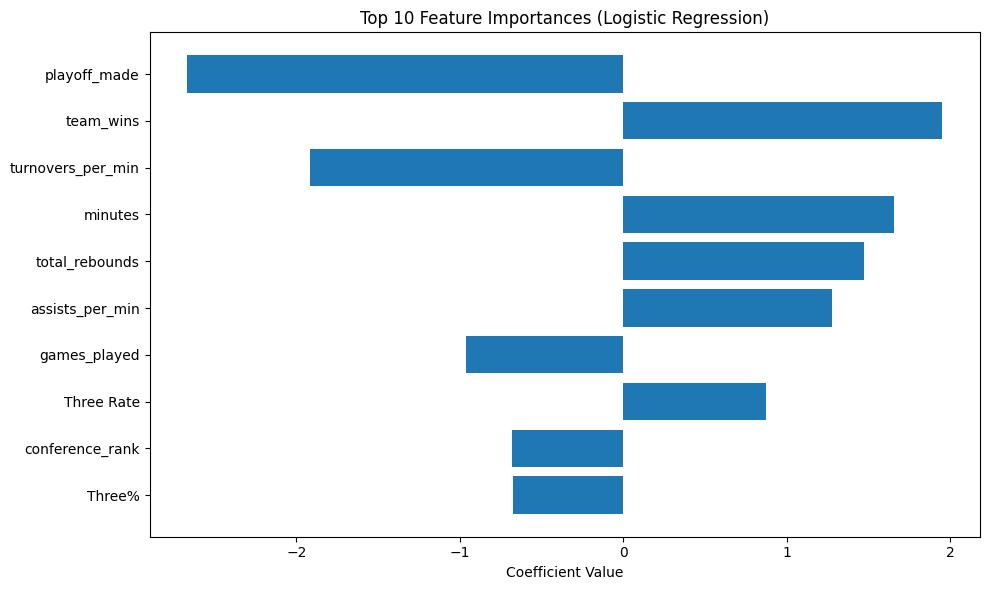

In [6]:
# Get feature importance from coefficients
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'coefficient': model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features = feature_importance.head(10)
plt.barh(top_features['feature'], top_features['coefficient'])
plt.xlabel('Coefficient Value')
plt.title('Top 10 Feature Importances (Logistic Regression)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top Predictions (Logistic Regression)

In [7]:
# Show top predictions
test_data['lr_prob'] = test_probs
test_data_sorted = test_data.sort_values('lr_prob', ascending=False)

print(f"\nYear {test_award_year} All-Star MVP Predictions (Logistic Regression):")
print(f"{'Rank':<6}{'Player':<20}{'Team':<6}{'Probability':<12}{'Actual'}")
print("-" * 55)
for idx, (_, row) in enumerate(test_data_sorted.head(10).iterrows(), 1):
    actual = "✅ WINNER" if row['Target'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<20}{row['team']:<6}{row['lr_prob']:.4f}{'':6}{actual}")


Year 10 All-Star MVP Predictions (Logistic Regression):
Rank  Player              Team  Probability Actual
-------------------------------------------------------
1     johnsvi01w          SAS   0.9645      
2     johnssh01w          HOU   0.9157      
3     youngso01w          SAS   0.8268      
4     tauradi01w          PHO   0.8143      
5     whaleli01w          CON   0.7604      
6     augusse01w          MIN   0.7125      
7     fordch01w           DET   0.7078      
8     smithta01w          PHO   0.6417      
9     mazzake01w          PHO   0.6368      
10    smithka01w          DET   0.6173      


## 1.2 XGBoost

In [8]:
# Train XGBoost
scale_pos_weight = len(y_train[y_train == 0]) / max(len(y_train[y_train == 1]), 1)

xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model.fit(X_train, y_train)

# Predictions
y_train_pred_xgb = xgb_model.predict(X_train)
y_test_pred_xgb = xgb_model.predict(X_test)
test_probs_xgb = xgb_model.predict_proba(X_test)[:, 1]

print("\n✅ XGBoost Model trained!")
print(f"Train accuracy: {accuracy_score(y_train, y_train_pred_xgb):.3f}")
print(f"Test accuracy: {accuracy_score(y_test, y_test_pred_xgb):.3f}")
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_xgb))


✅ XGBoost Model trained!
Train accuracy: 1.000
Test accuracy: 0.989

Classification Report (Test):
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        88
           1       0.00      0.00      0.00         1

    accuracy                           0.99        89
   macro avg       0.49      0.50      0.50        89
weighted avg       0.98      0.99      0.98        89



### Feature Importance (XGBoost)


Top 10 Most Important Features (XGBoost):
          feature  importance
        team_wins    0.426843
     games_played    0.158940
              FT%    0.140163
     total_points    0.112300
          minutes    0.052689
       Three Rate    0.020588
           Three%    0.019356
   total_rebounds    0.012651
turnovers_per_min    0.012614
   steals_per_min    0.011346


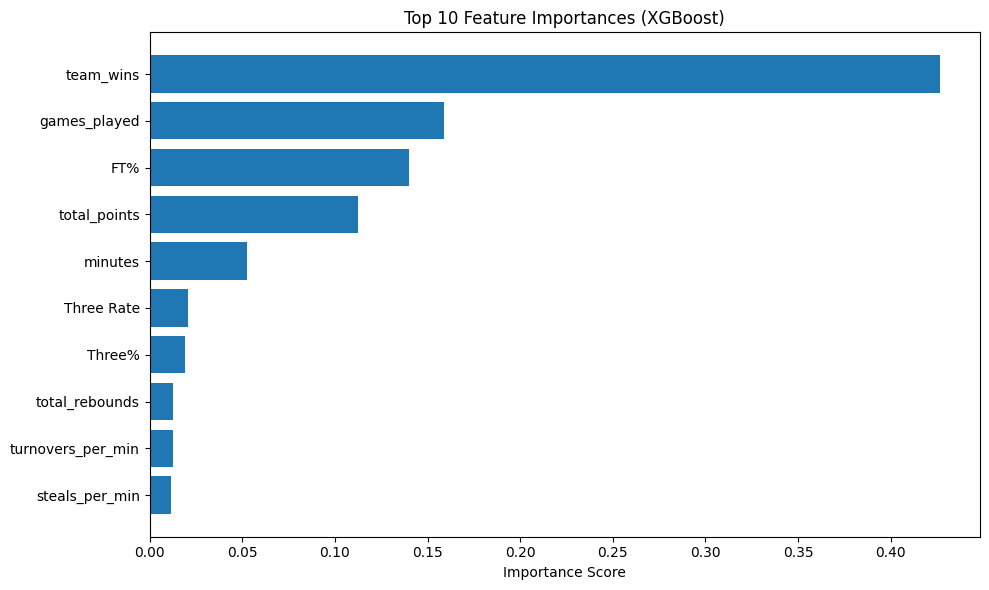

In [9]:
# Get feature importance
feature_importance_xgb = pd.DataFrame({
    'feature': feature_columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 10 Most Important Features (XGBoost):")
print(feature_importance_xgb.head(10).to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
top_features_xgb = feature_importance_xgb.head(10)
plt.barh(top_features_xgb['feature'], top_features_xgb['importance'])
plt.xlabel('Importance Score')
plt.title('Top 10 Feature Importances (XGBoost)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

### Top Predictions (XGBoost)

In [10]:
# Show top predictions
test_data['xgb_prob'] = test_probs_xgb
test_data_sorted_xgb = test_data.sort_values('xgb_prob', ascending=False)

print(f"\nYear {test_award_year} All-Star MVP Predictions (XGBoost):")
print(f"{'Rank':<6}{'Player':<20}{'Team':<6}{'Probability':<12}{'Actual'}")
print("-" * 55)
for idx, (_, row) in enumerate(test_data_sorted_xgb.head(10).iterrows(), 1):
    actual = "✅ WINNER" if row['Target'] == 1 else ""
    print(f"{idx:<6}{row['playerID']:<20}{row['team']:<6}{row['xgb_prob']:.4f}{'':6}{actual}")


Year 10 All-Star MVP Predictions (XGBoost):
Rank  Player              Team  Probability Actual
-------------------------------------------------------
1     johnsvi01w          SAS   0.3938      
2     wautean01w          SAS   0.2126      
3     augusse01w          MIN   0.0237      
4     youngso01w          SAS   0.0121      
5     dupreca01w          CHI   0.0047      
6     jonesas01w          CON   0.0045      
7     thompti01w          HOU   0.0039      
8     parkeca01w          LAS   0.0036      
9     leslili01w          LAS   0.0034      
10    hammobe01w          SAS   0.0033      


---
# Section 2: Multi-Year Evaluation (Leave-One-Out Cross-Validation)
Evaluate models across all available years

In [11]:
# Walk-Forward Cross-Validation Loop (Expand Window)
# Train on years [min_year, ..., T-1], Test on year T

# Note: In this notebook, 'next_year' represents the award year
award_years = sorted(candidates['next_year'].unique())
results = []
min_year = min(award_years)

# Start loop from the 3rd available year to have at least 2 years of training data
start_idx = 2 
if start_idx >= len(award_years):
    start_idx = 1 # Fallback

print(f"Running Walk-Forward Cross-Validation...")
print(f"{'Test Year':<10}{'Train Years':<15}{'LR Top1':<10}{'XGB Top1':<10}{'LR Rank':<10}{'XGB Rank':<10}{'Winner'}")
print("-" * 85)

for i in range(start_idx, len(award_years)):
    test_year = award_years[i]
    
    # Walk-Forward Split: Train on ALL years prior to test_year
    train_mask = candidates['next_year'] < test_year
    test_mask = candidates['next_year'] == test_year
    
    train_data_cv = candidates[train_mask].copy()
    test_data_cv = candidates[test_mask].copy()
    
    if len(test_data_cv) == 0 or len(train_data_cv) == 0:
        continue
        
    X_train_cv = train_data_cv[feature_columns]
    y_train_cv = train_data_cv['Target']
    X_test_cv = test_data_cv[feature_columns]
    y_test_cv = test_data_cv['Target']
    
    # --- Logistic Regression ---
    scaler_cv = StandardScaler()
    X_train_scaled_cv = scaler_cv.fit_transform(X_train_cv)
    X_test_scaled_cv = scaler_cv.transform(X_test_cv)
    
    lr_model_cv = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
    lr_model_cv.fit(X_train_scaled_cv, y_train_cv)
    
    lr_prob_cv = lr_model_cv.predict_proba(X_test_scaled_cv)[:, 1]
    
    # --- XGBoost ---
    scale_pos_weight_cv = len(y_train_cv[y_train_cv == 0]) / max(len(y_train_cv[y_train_cv == 1]), 1)
    
    xgb_model_cv = xgb.XGBClassifier(
        objective='binary:logistic',
        scale_pos_weight=scale_pos_weight_cv,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        random_state=42,
        verbosity=0
    )
    xgb_model_cv.fit(X_train_cv, y_train_cv)
    xgb_prob_cv = xgb_model_cv.predict_proba(X_test_cv)[:, 1]
    
    # --- Metrics: Top K & Rank ---
    test_data_cv['lr_prob'] = lr_prob_cv
    test_data_cv['xgb_prob'] = xgb_prob_cv
    
    # Sort by probability
    lr_sorted = test_data_cv.sort_values('lr_prob', ascending=False).reset_index(drop=True)
    xgb_sorted = test_data_cv.sort_values('xgb_prob', ascending=False).reset_index(drop=True)
    
    actual_winner_row = test_data_cv[test_data_cv['Target'] == 1]
    
    lr_rank = np.nan
    xgb_rank = np.nan
    winner_id = "Unknown"
    
    if len(actual_winner_row) > 0:
        winner_id = actual_winner_row.iloc[0]['playerID']
        
        # Find Rank
        lr_rank_idx = lr_sorted[lr_sorted['playerID'] == winner_id].index
        xgb_rank_idx = xgb_sorted[xgb_sorted['playerID'] == winner_id].index
        if len(lr_rank_idx) > 0: lr_rank = lr_rank_idx[0] + 1
        if len(xgb_rank_idx) > 0: xgb_rank = xgb_rank_idx[0] + 1
    
    # Check Top K
    lr_top1 = 1 if lr_rank == 1 else 0
    lr_top5 = 1 if lr_rank <= 5 else 0
    lr_top10 = 1 if lr_rank <= 10 else 0
    
    xgb_top1 = 1 if xgb_rank == 1 else 0
    xgb_top5 = 1 if xgb_rank <= 5 else 0
    xgb_top10 = 1 if xgb_rank <= 10 else 0
    
    train_years_str = f"{min_year}-{test_year-1}"
    print(f"{test_year:<10}{train_years_str:<15}{lr_top1:<10}{xgb_top1:<10}{lr_rank:<10}{xgb_rank:<10}{winner_id}")
    
    results.append({
        'Test_Year': test_year,
        'LR_Rank': lr_rank,
        'XGB_Rank': xgb_rank,
        'LR_Top1': lr_top1, 'LR_Top5': lr_top5, 'LR_Top10': lr_top10,
        'XGB_Top1': xgb_top1, 'XGB_Top5': xgb_top5, 'XGB_Top10': xgb_top10
    })


Running Walk-Forward Cross-Validation...
Test Year Train Years    LR Top1   XGB Top1  LR Rank   XGB Rank  Winner
-------------------------------------------------------------------------------------
4         2-3            0         0         20        46        teaslni01w
5         2-4            0         0         nan       nan       Unknown
6         2-5            0         0         74        45        swoopsh01w
7         2-6            0         0         33        30        douglka01w
8         2-7            0         0         14        68        fordch01w
9         2-8            0         0         nan       nan       Unknown
10        2-9            0         0         23        46        cashsw01w
11        2-10           0         0         nan       nan       Unknown


## Summary of Multi-Year Results


===== Walk-Forward Validation Results =====
Metric                       | Logistic Reg | XGBoost
----------------------------------------------------------
Top-1 Accuracy               | 0.0%        | 0.0%
Top-5 Accuracy               | 0.0%        | 0.0%
Top-10 Accuracy              | 0.0%        | 0.0%
Average Rank                 | 32.8          | 47.0
Rank Std Dev (Consistency)   | 24.0          | 13.6


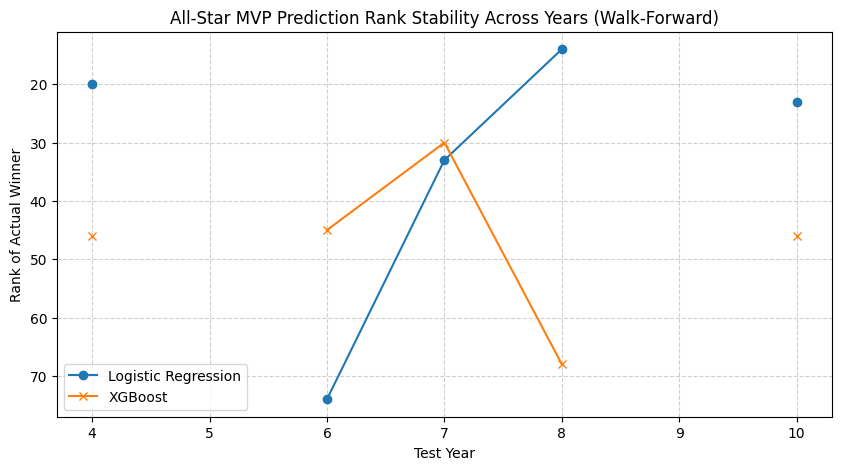

In [12]:
results_df = pd.DataFrame(results)

print("\n===== Walk-Forward Validation Results =====")
print("Metric                       | Logistic Reg | XGBoost")
print("----------------------------------------------------------")
print(f"Top-1 Accuracy               | {results_df['LR_Top1'].mean():.1%}        | {results_df['XGB_Top1'].mean():.1%}")
print(f"Top-5 Accuracy               | {results_df['LR_Top5'].mean():.1%}        | {results_df['XGB_Top5'].mean():.1%}")
print(f"Top-10 Accuracy              | {results_df['LR_Top10'].mean():.1%}        | {results_df['XGB_Top10'].mean():.1%}")
print(f"Average Rank                 | {results_df['LR_Rank'].mean():.1f}          | {results_df['XGB_Rank'].mean():.1f}")
print(f"Rank Std Dev (Consistency)   | {results_df['LR_Rank'].std():.1f}          | {results_df['XGB_Rank'].std():.1f}")

# Plot Rank Variation
plt.figure(figsize=(10, 5))
plt.plot(results_df['Test_Year'], results_df['LR_Rank'], marker='o', label='Logistic Regression')
plt.plot(results_df['Test_Year'], results_df['XGB_Rank'], marker='x', label='XGBoost')
plt.gca().invert_yaxis()  # Rank 1 is at top
plt.title('All-Star MVP Prediction Rank Stability Across Years (Walk-Forward)')
plt.ylabel('Rank of Actual Winner')
plt.xlabel('Test Year')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()


---
# Section 3: Predict for New Year
Use this section to predict All-Star MVP for a future year using past data

## 3.1 Train Final Models on All Available Data

In [13]:
# Train on ALL available data (years 1-10)
all_train_data = candidates[candidates['year'].isin([1,2,3,4,5,6,7,8,9,10])].copy()
X_all = all_train_data[feature_columns]
y_all = all_train_data['Target']

# Train Logistic Regression
scaler_final = StandardScaler()
X_all_scaled = scaler_final.fit_transform(X_all)
model_final = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_final.fit(X_all_scaled, y_all)

# Train XGBoost
scale_pos_weight_final = len(y_all[y_all == 0]) / max(len(y_all[y_all == 1]), 1)
xgb_model_final = xgb.XGBClassifier(
    objective='binary:logistic',
    scale_pos_weight=scale_pos_weight_final,
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42,
    verbosity=0
)
xgb_model_final.fit(X_all, y_all)

print("✅ Final models trained on all available data (Years 1-10)")

✅ Final models trained on all available data (Years 1-10)


## 3.2 Load New Year Data and Predict

In [14]:
# Predict All-Star MVP for new year using previous year stats
# Example: year_10_players_teams_test.csv → use year 9 stats → predict year 10 All-Star MVP

# new_year_file = "../../data/yearly_data/year_10_players_teams_test.csv"
new_year_file = "../../data/test_data/players_teams.csv"
predict_year = 11
stats_year = predict_year - 1

print(f"Predicting Year {predict_year} All-Star MVP using Year {stats_year} stats")

# Load new year player list
new_year_players = pd.read_csv(new_year_file)
print(f"Players in year {predict_year}: {len(new_year_players)}")

# Get year N-1 stats for these players
player_stats = mvp_data[
    (mvp_data['year'] == stats_year) &
    (mvp_data['playerID'].isin(new_year_players['playerID']))
].copy()

# Filter to All-Star MVP candidates
new_candidates = player_stats[
    (player_stats['minutes'] >= 500) &
    (player_stats['games_played'] >= 20)
].copy()

print(f"All-Star MVP candidates: {len(new_candidates)}")

Predicting Year 11 All-Star MVP using Year 10 stats
Players in year 11: 148
All-Star MVP candidates: 67


### Predictions with Logistic Regression

In [15]:
# Predict with Logistic Regression
X_new = new_candidates[feature_columns]
X_new_scaled = scaler_final.transform(X_new)
new_candidates['lr_probability'] = model_final.predict_proba(X_new_scaled)[:, 1]
new_candidates_sorted_lr = new_candidates.sort_values('lr_probability', ascending=False)

print(f"\nYear {predict_year} All-Star MVP Predictions (Logistic Regression):")
print(f"{'Rank':<6}{'Player':<25}{'Team':<6}{'Probability':<12}{'PPG':<8}{'Wins'}")
print("-" * 70)
for idx, (_, row) in enumerate(new_candidates_sorted_lr.head(15).iterrows(), 1):
    ppg = row['total_points'] / row['games_played']
    print(f"{idx:<6}{row['playerID']:<25}{row['team']:<6}{row['lr_probability']:.4f}{'':6}{ppg:.1f}{'':6}{int(row['team_wins'])}")

print(f"\n🏆 Predicted All-Star MVP (LR): {new_candidates_sorted_lr.iloc[0]['playerID']}")


Year 11 All-Star MVP Predictions (Logistic Regression):
Rank  Player                   Team  Probability PPG     Wins
----------------------------------------------------------------------
1     dupreca01w               CHI   0.9086      15.7      16
2     cashsw01w                SEA   0.8275      12.2      20
3     parkeca01w               LAS   0.8107      13.1      18
4     pondeca01w               PHO   0.6665      19.1      23
5     thompti01w               LAS   0.6217      13.0      18
6     birdsu01w                SEA   0.6170      12.8      20
7     whaleli01w               CON   0.5276      12.3      16
8     hodgero01w               MIN   0.5102      9.9      14
9     smithta01w               PHO   0.4037      9.9      23
10    penicti01w               SAC   0.3506      4.9      12
11    tauradi01w               PHO   0.3126      20.4      23
12    johnste01w               PHO   0.1463      9.6      23
13    bonnede01w               PHO   0.1412      11.2      23
14    ja

### Predictions with XGBoost

In [16]:
# Predict with XGBoost
new_candidates['xgb_probability'] = xgb_model_final.predict_proba(X_new)[:, 1]
new_candidates_sorted_xgb = new_candidates.sort_values('xgb_probability', ascending=False)

print(f"\nYear {predict_year} All-Star MVP Predictions (XGBoost):")
print(f"{'Rank':<6}{'Player':<25}{'Team':<6}{'Probability':<12}{'PPG':<8}{'Wins'}")
print("-" * 70)
for idx, (_, row) in enumerate(new_candidates_sorted_xgb.head(15).iterrows(), 1):
    ppg = row['total_points'] / row['games_played']
    print(f"{idx:<6}{row['playerID']:<25}{row['team']:<6}{row['xgb_probability']:.4f}{'':6}{ppg:.1f}{'':6}{int(row['team_wins'])}")

print(f"\n🏆 Predicted All-Star MVP (XGBoost): {new_candidates_sorted_xgb.iloc[0]['playerID']}")


Year 11 All-Star MVP Predictions (XGBoost):
Rank  Player                   Team  Probability PPG     Wins
----------------------------------------------------------------------
1     beviltu01w               IND   0.0067      6.1      22
2     hodgero01w               MIN   0.0050      9.9      14
3     kraayca01w               NYL   0.0041      9.0      13
4     snellbe01w               SAS   0.0037      6.2      15
5     youngso01w               SAS   0.0033      18.2      15
6     whaleli01w               CON   0.0032      12.3      16
7     mooreje01w               IND   0.0021      4.8      22
8     whiteta01w               CON   0.0020      9.5      16
9     perkiji01w               CHI   0.0019      13.2      16
10    douglka01w               IND   0.0019      17.6      22
11    bonnede01w               PHO   0.0018      11.2      23
12    pondeca01w               PHO   0.0018      19.1      23
13    philler01w               CON   0.0015      8.1      16
14    carsoes01w       

### Check Actual Winner (if available)

In [17]:
# Check if we have the actual winner for this year
actual_winner = mvp_data[(mvp_data['year'] == predict_year) & (mvp_data['MVP_winner'] == 1)]

if len(actual_winner) > 0:
    actual_mvp_id = actual_winner.iloc[0]['playerID']
    print(f"\n✅ Actual All-Star MVP for Year {predict_year}: {actual_mvp_id}")
    
    # Check if actual winner is in our predictions
    lr_prob_actual = new_candidates[new_candidates['playerID'] == actual_mvp_id]['lr_probability']
    xgb_prob_actual = new_candidates[new_candidates['playerID'] == actual_mvp_id]['xgb_probability']
    
    if len(lr_prob_actual) > 0:
        lr_rank_actual = new_candidates_sorted_lr[new_candidates_sorted_lr['playerID'] == actual_mvp_id].index[0] + 1
        print(f"   Logistic Regression - Rank: {lr_rank_actual}, Probability: {lr_prob_actual.values[0]:.4f}")
    
    if len(xgb_prob_actual) > 0:
        xgb_rank_actual = new_candidates_sorted_xgb[new_candidates_sorted_xgb['playerID'] == actual_mvp_id].index[0] + 1
        print(f"   XGBoost - Rank: {xgb_rank_actual}, Probability: {xgb_prob_actual.values[0]:.4f}")
else:
    print(f"\n⚠️ No actual winner data available for Year {predict_year}")


⚠️ No actual winner data available for Year 11
